# Super Res Model Inference

In [1]:
from torch import nn
import torch

### The model components

In [2]:
def conv_layer(in_,out_,ks, stride,activation = True):
    layers = [
        nn.Conv2d(in_,out_,kernel_size = ks, stride = stride, padding = ks//2, bias = False),
        nn.BatchNorm2d(out_),
    ]
    if activation: layers.append(nn.LeakyReLU())
    return nn.Sequential(*layers)

class res_block(nn.Module):
    def __init__(self,nb_filter):
        """
        simple resnet block
        """
        super(res_block,self).__init__()
        self.nb_filter = nb_filter
        self.clayer1 = conv_layer(self.nb_filter,self.nb_filter,3,(1,1))
        self.clayer2 = conv_layer(self.nb_filter,self.nb_filter,3,(1,1),activation = False)
    
    def forward(self,x):
        x2 = self.clayer2(self.clayer1(x))
        return x2+x
    
def up_block(nb_filters):
    layers = [nn.Upsample(scale_factor=2),
                conv_layer(nb_filters,nb_filters,3,stride = (1,1),activation=True),
             ]
    return nn.Sequential(*layers)

### The Model

In [3]:
class small2big(nn.Module):
    def __init__(self,nb_filters=64):
        super(small2big,self).__init__()
        self.nb_filters = nb_filters
        self.input_conv = conv_layer(in_=3,out_=self.nb_filters,ks=9,stride=1)
        self.res_blocks = nn.Sequential(*list(res_block(self.nb_filters) for i in range(6)))
        self.up = nn.Sequential(*list(up_block(self.nb_filters) for i in range(1)))
        self.output_conv = nn.Sequential(*[
            nn.Conv2d(in_channels=self.nb_filters,out_channels=3,kernel_size=5,stride=(1,1),padding = 2),
            nn.Sigmoid(),
                                          ])
        
    def forward(self,x):
        x = self.input_conv(x)
        x = self.res_blocks(x)
        x = self.up(x)
        x = self.output_conv(x)
        return x
    
def load_model(model,path):
    model.load_state_dict(torch.load(path))

In [27]:
model = small2big()
load_model(model, "super_res_0.0.1.npy")

In [28]:
from torchvision import transforms
from PIL import Image
totensor = transforms.ToTensor()
toimg = transforms.ToPILImage()
crop = transforms.CenterCrop((224,224))

In [29]:
def super_pic(path):
    img = Image.open(path)#.resize((300,300))
    tensor = totensor(img).unsqueeze(0)[:,:3,:,:]
    s_img = toimg(model(tensor)[0])
    return img,s_img

In [30]:
img,s_img=super_pic("/data/low_res/001.jpg")

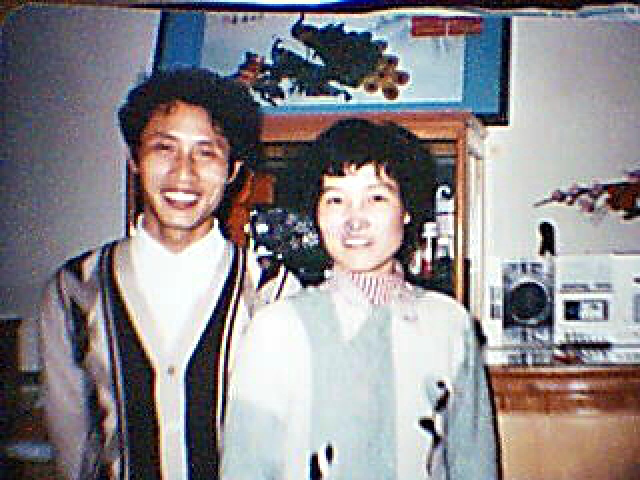

In [31]:
img.resize((img.width*2,img.height*2))

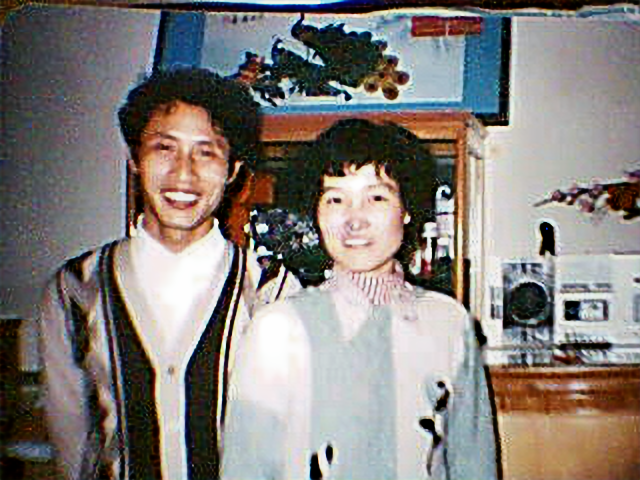

In [32]:
s_img

In [33]:
img,s_img=super_pic("/data/low_res/002.jpg")

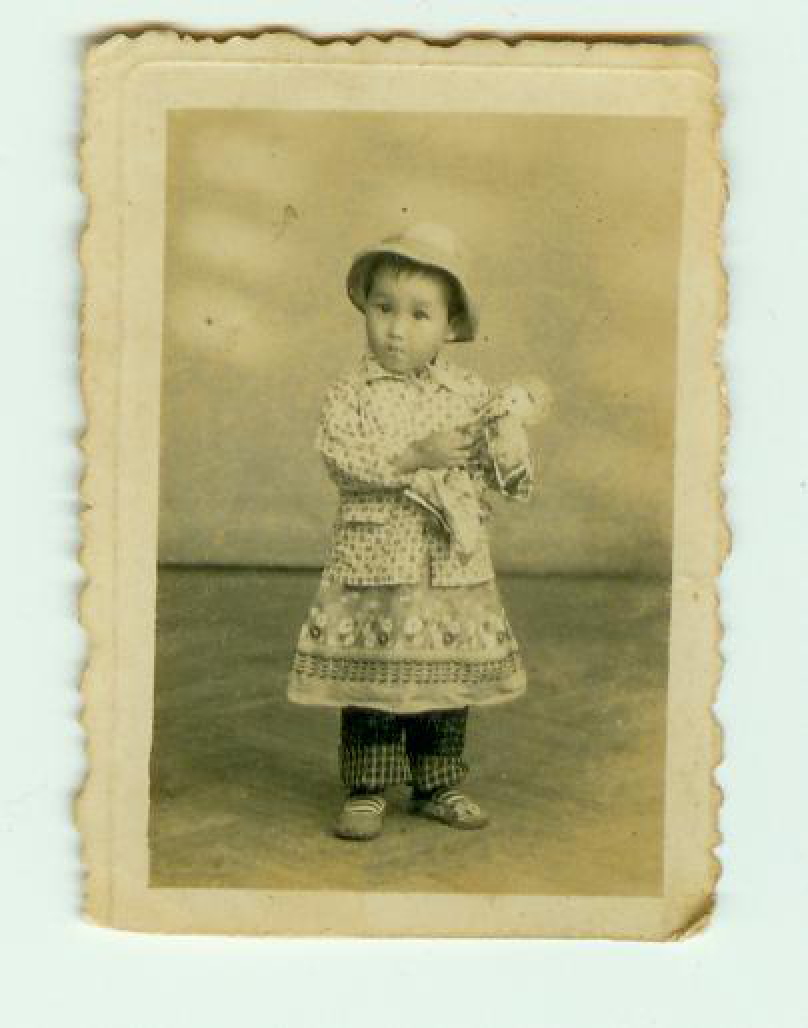

In [34]:
img.resize((img.width*2,img.height*2))

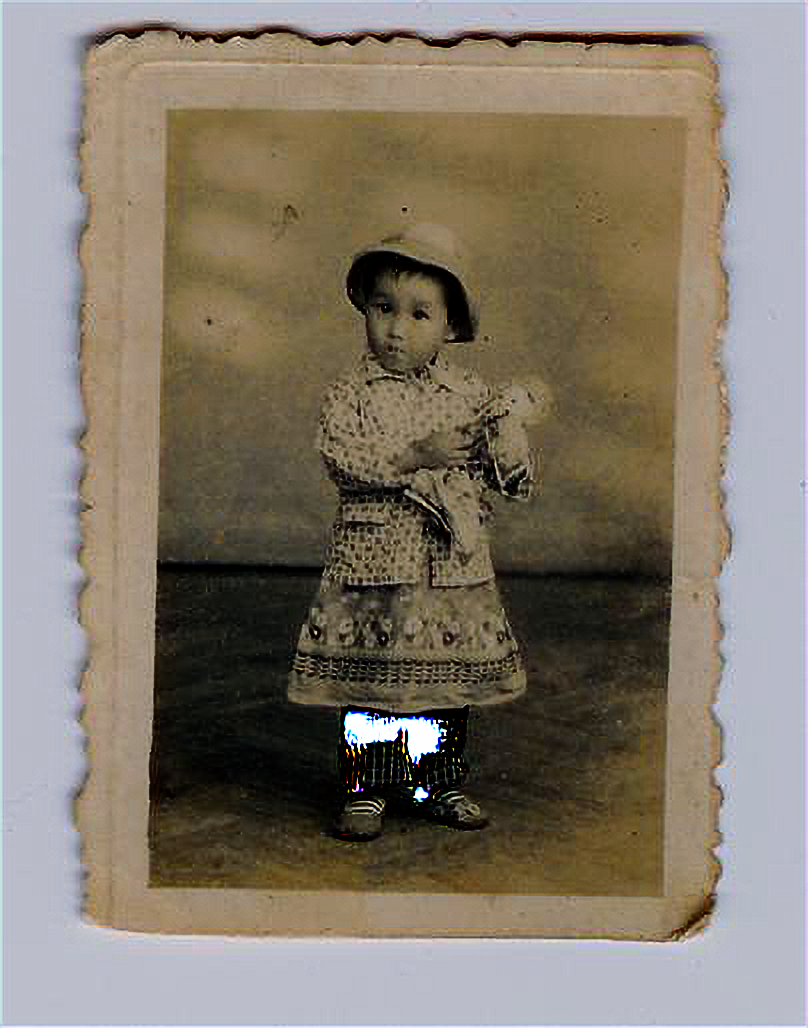

In [35]:
s_img

In [36]:
img,s_img=super_pic("/data/low_res/003.jpg")

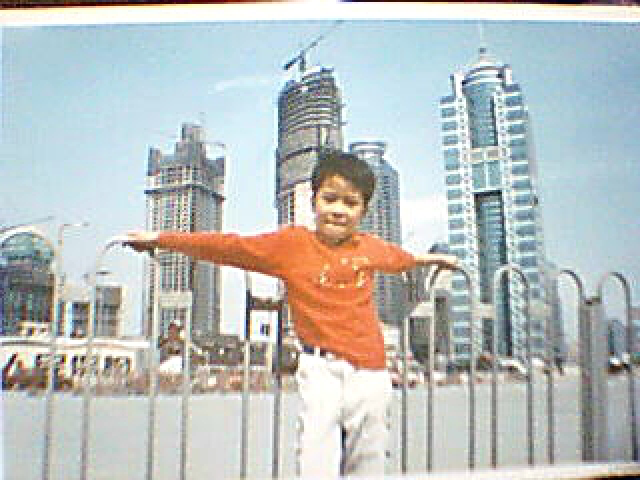

In [37]:
img.resize((img.width*2,img.height*2))

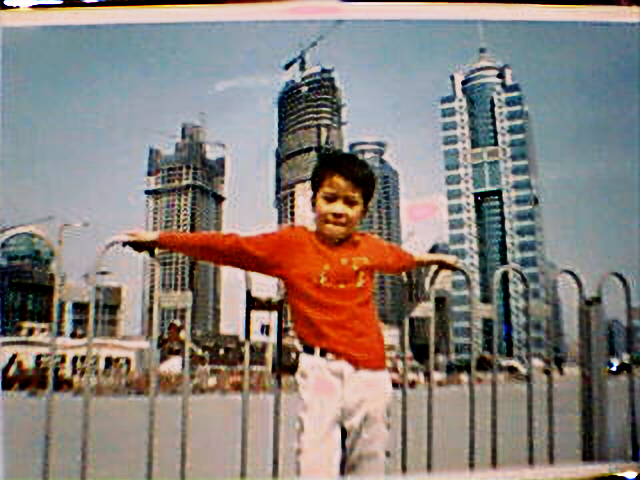

In [38]:
s_img

In [39]:
img,s_img=super_pic("/data/low_res/004.jpg")

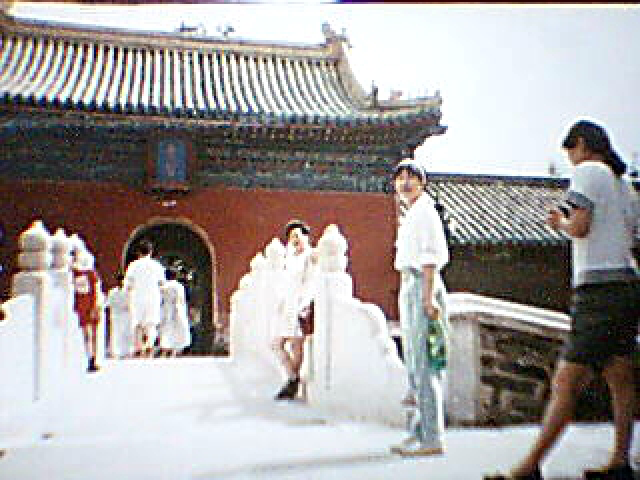

In [40]:
img.resize((img.width*2,img.height*2))

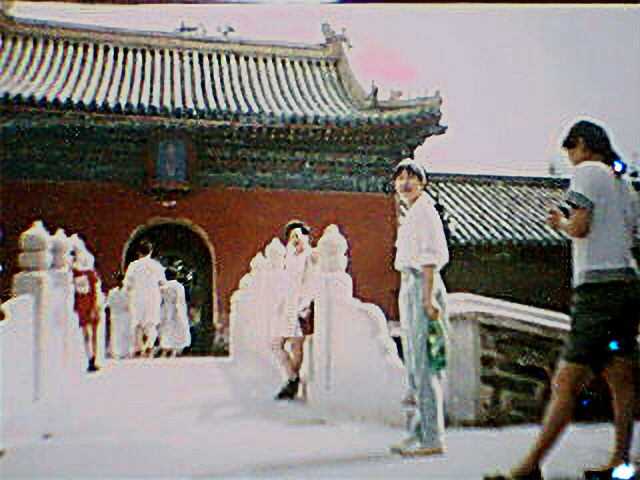

In [41]:
s_img

In [42]:
img,s_img=super_pic("/data/low_res/005.jpg")

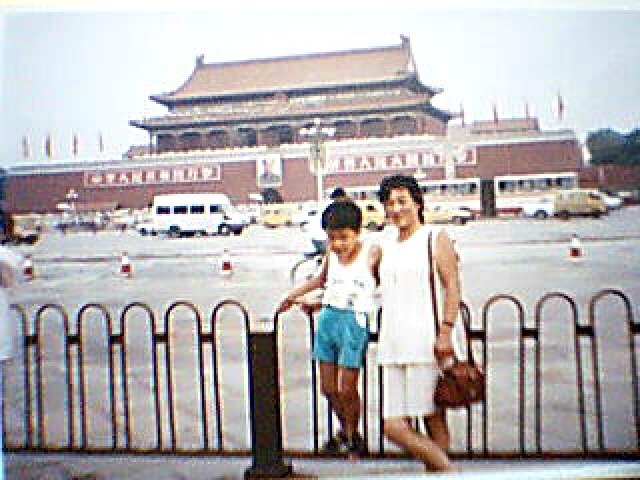

In [43]:
img.resize((img.width*2,img.height*2))

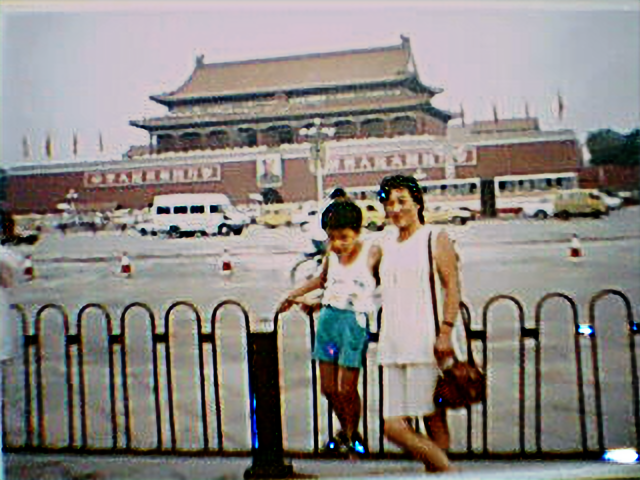

In [44]:
s_img

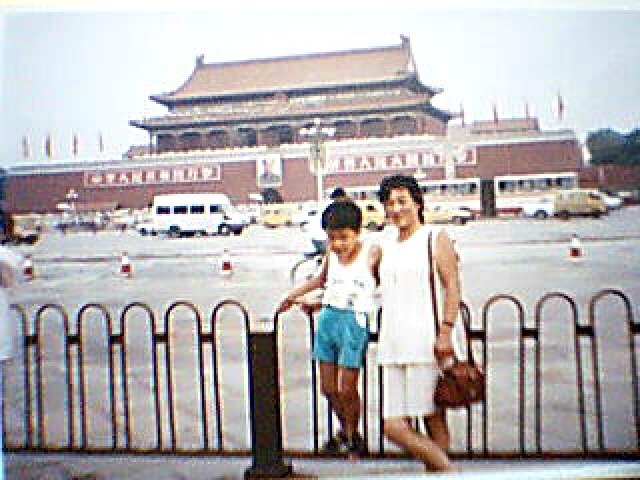

In [45]:
img.resize((img.width*2,img.height*2))

### Content Loss

In [46]:
from torchvision.models.vgg import vgg16_bn

In [47]:
vgg = vgg16_bn(pretrained=True)

In [48]:
vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNor

In [49]:
vgg_2blocks = vgg.features[:14]

In [50]:
content = crop(Image.open("/data/unlabeled2017/000000001032.jpg"))

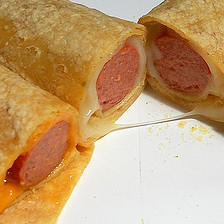

In [51]:
content

In [52]:
start = torch.rand(1,3,224,224)
start_param = nn.Parameter(data=start,requires_grad = True)

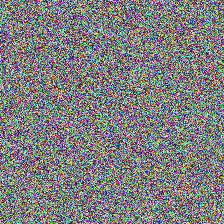

In [53]:
toimg(start[0])

In [54]:
act1 = vgg_2blocks(totensor(content).unsqueeze(0))
act2 = vgg_2blocks(start)
act1.size(),act2.size()

(torch.Size([1, 128, 56, 56]), torch.Size([1, 128, 56, 56]))

In [55]:
from torch.optim import Adam
loss_func = nn.MSELoss()
opt = Adam([start_param,])


In [62]:
act1 = vgg_2blocks(totensor(content).unsqueeze(0))
for i in range(200):
    opt.zero_grad()
    act2 = vgg_2blocks(start_param)
    loss = loss_func(act2, act1.detach())
    loss.backward()
    opt.step()

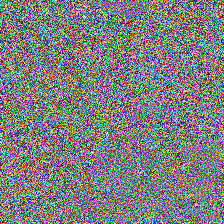

In [61]:
toimg(start_param.data[0])